In [ ]:
# # Run only first time
# path = '/content/drive/MyDrive/Colab Notebooks/Trash-Expo/trash.zip'
# !unzip '/content/drive/MyDrive/Colab Notebooks/Trash-Expo/trash.zip' -d '/content/drive/MyDrive/Colab Notebooks/Trash-Expo'

In [ ]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
# from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
# from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


In [ ]:
pth = '/content/drive/MyDrive/Colab Notebooks/Trash-Expo/garbage_classification/'
classes = os.listdir(pth)
classes
# for c in classes:
#   print(pth+c)
# os.listdir(pth+c)

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

## Constants

In [ ]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "/content/drive/MyDrive/Colab Notebooks/Trash-Expo/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


## DataFrame


We want to create a data frame that has in one column the filenames of all our images and in the other column the corresponding category. We Open the directories in the dataset one by one, save the filenames in the filenames_list and add the corresponding category in the categories_list


In [ ]:
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [ ]:
df.head()

,filename,category
0,clothes/clothes1825.jpg,7
1,paper/paper433.jpg,0
2,brown-glass/brown-glass356.jpg,9
3,clothes/clothes1126.jpg,7
4,plastic/plastic704.jpg,2


paper/paper531.jpg


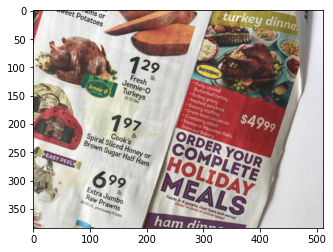

In [ ]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

## Visualize the Categories Distribution

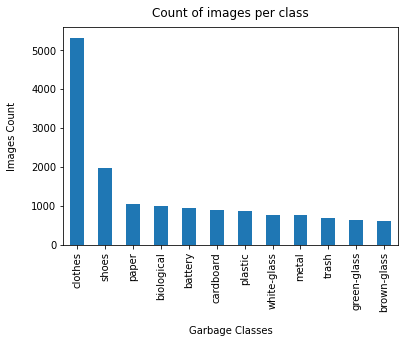

In [ ]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);


## Create the model

The steps are:

* Create an xception model without the last layer and load the ImageNet pretrained weights
* Add a pre-processing layer
* Add a pooling layer followed by a softmax layer at the end



In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = '/content/drive/MyDrive/Colab Notebooks/Trash-Expo/xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 320, 320, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 12)                24588     
                                                                 
Total params: 20,886,068
Trainable params: 24,588
Non-trainable params: 20,861,480
_________________________________________________________________


#### We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.


In [ ]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)
callbacks = [early_stop]
print('call back defined!')

call back defined!




#We split the training set into three separate sets:

    1. The training set: used to train our model.
    2. The validation set: used to double check that our model is not overfitting the training set, i.e. it can also generalise to other data other than the train data
    3. The Test set: Used to estimate the accuracy of the model on new data other than the ones the model used for training For a competition or for some other cases, you can split the data only to training and validation sets in order to achieve the highest possible accuracy, without the need to properly estimate how accurate the model really is.

We split the data set as follows: 80% train set, 10% cross_validation set, and 10% test set


In [ ]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


## Train the model

We will first create the training data generator, that will get the images from the input data directory to train on them. We will also create a generator for the validation set.

Applying Data Augmentation on the training set was taking too long to be executed and the initial results didn't show much improvement than the results without augmentation, so I commented the augmentation to make the training faster. However fell free to uncomment the Data Augmentation lines in the following cell and play a bit with it.


In [ ]:
batch_size=64

train_datagen = image.ImageDataGenerator(    
    ###  Augmentation Start  ###
    
    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2
    
    ##  Augmentation End  ###
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [ ]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


## Train

In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
 15/193 [=>............................] - ETA: 40:13 - loss: 2.0325 - categorical_accuracy: 0.2979

KeyboardInterrupt: ignored

## Load

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Trash-Expo/model.h5')

In [ ]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 12 classes.


In [ ]:
# filenames = test_generator.filenames
# nb_samples = len(filenames)

# _, accuracy = model.evaluate_generator(test_generator, nb_samples)

# print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ') 

In [ ]:
# filenames = test_generator.filenames
# nb_samples = len(filenames)
# # nb_samples
# test_generator

In [ ]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


Test on image

In [ ]:
import numpy as np
from keras.preprocessing import image

img_width, img_height = 320,320
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/Trash-Expo/avatar.jpg', target_size = (img_width, img_height))
dis = img
img = image.img_to_array(img)
dis1 = img
img = np.expand_dims(img, axis = 0)

In [ ]:
img.shape

(1, 320, 320, 3)

In [ ]:
pred = model.predict(img)

In [ ]:
pred = pred.argmax(1)

In [ ]:
pred

array([4])

In [ ]:
pred = [gen_label_map[item] for item in pred]

In [ ]:
pred


['clothes']

In [ ]:
ogimg = image.array_to_img(dis1)
# ogimg
dis1.shape

(320, 320, 3)

The predicted object belongs to clothes


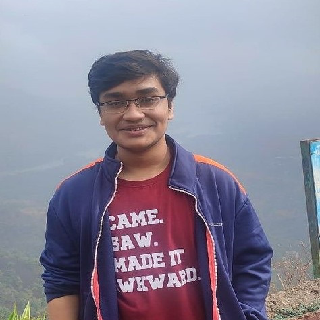

In [ ]:
print('The predicted object belongs to',pred[0])
ogimg

In [ ]:
# # Convert the model
# converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/Colab Notebooks/Trash-Expo/model.h5') # path to the SavedModel directory
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Trash-Expo/model.h5')
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()
# open("model.tflite", "wb").write(tflite_model)


ValueError: ignored

In [ ]:
import tensorflow as tf

# Convert the model
pth = '/content/drive/MyDrive/Colab Notebooks/Trash-Expo/model.h5'
converter = tf.lite.TFLiteConverter.from_saved_model(pth) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


OSError: ignored